In [1]:
import gymnasium as gym
from bettermdptools.envs.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
import rl
from rl import RL as RL
from myutils import test_env
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from planner import PlannerR

In [2]:
from multiprocessing import Pool
import workers_a4
import os

def bj_expected_reward_history(pi_track, output_step, n_episodes=1000, nproc=4):
    e_track = list(range(0, len(pi_track), output_step))
    if e_track[-1] < len(pi_track)-1: e_track += [len(pi_track)-1]
    parameters = []
    output_file = 'temp'
    for e in e_track:
        parameters.append((e, pi_track[e], n_episodes, output_file))
        
    if __name__ ==  '__main__':
        p=Pool(processes = nproc)
        p.map(workers_a4.bj_expected_reward, parameters)

    R_track = np.loadtxt(output_file, delimiter=' ')
    R_track = R_track[R_track[:, 0].argsort()]
    os.remove(output_file)

    return R_track

In [3]:
base_env = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env)

#create actions dictionary and set map size
blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

In [4]:
from bettermdptools.utils.decorators import add_to
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    xticklabels = ['2','3','4','5','6','7','8','9','10','A']
    yticklabels = ['H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21',
                   'S12','S13','S14','S15','S16','S17','S18','S19','S20','S21','BJ']
    ax = sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("magma_r", as_cmap=True),
        linewidths=0.7,
        linecolor="black", xticklabels=xticklabels, yticklabels=yticklabels
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Dealer's card value", fontsize=13) 
    ax.set_ylabel("Player's hand", fontsize=13)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

#def test_env(env, n_iters, pi, convert_state_obs=lambda state: state):
#    test_scores = np.full([n_iters], np.nan)
#    for i in range(0, n_iters):
#        state, info = env.reset(seed=i)
#        done = False
#        state = convert_state_obs(state)
#        total_reward = 0
#        while not done:
#            action = pi[state]
#            next_state, reward, terminated, truncated, info = env.step(action)
#            done = terminated or truncated
#            next_state = convert_state_obs(next_state)
#            state = next_state
#            total_reward += reward
#        test_scores[i] = total_reward
#        env.close()
#    return test_scores

In [20]:
0.0*0.087323-1.0*0.479979+1.0*0.432698

-0.04728099999999996

VI wall clock time: 0.02864600000611972


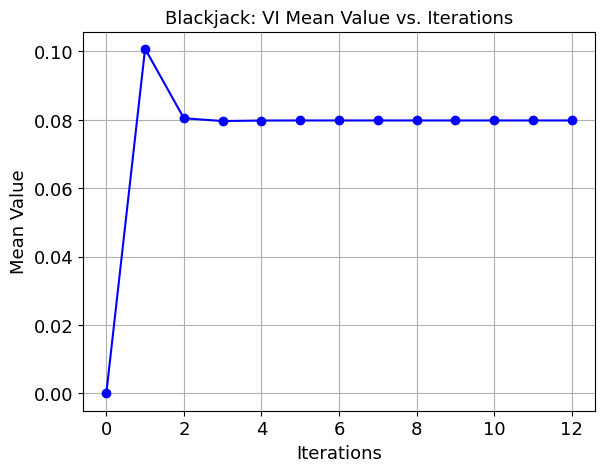

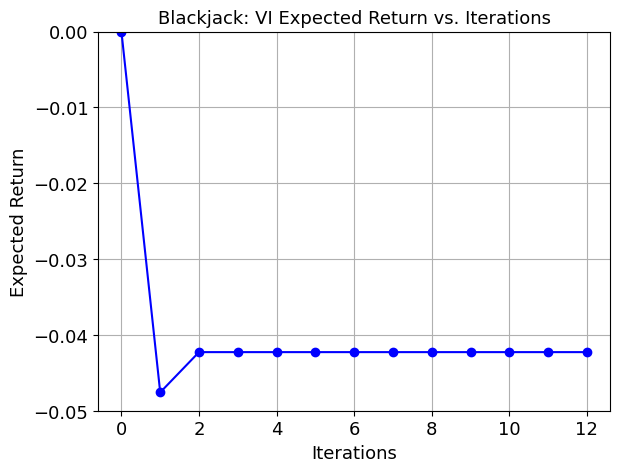

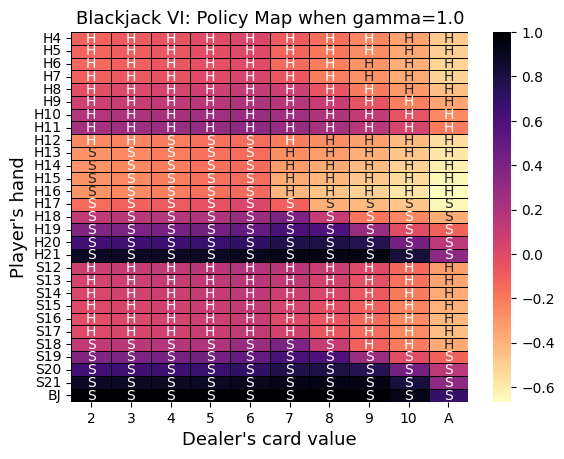

-0.042273
0.952387522740087
[-1.  0.  1.]
[475551  91171 433278]


In [32]:
# run VI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(blackjack.P, blackjack).value_iteration(gamma=1.0, n_iters=1000, theta=1e-10)
toc = time.perf_counter()
print(f'VI wall clock time: {toc-tic}')

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=1000000, nproc=6)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(mean_v_per_iter.shape[0]), mean_v_per_iter, '-o', color='blue')
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack: VI Mean Value vs. Iterations', fontsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

#mean_r_per_iter = np.trim_zeros(R_track, 'b')

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue')
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack: VI Expected Return vs. Iterations', fontsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
ax.set_ylim(-0.05, 0)
plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack VI: Policy Map when gamma=1.0"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

#test policy
test_scores = test_env(env=blackjack, n_iters=1000000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

unique_values, counts = np.unique(test_scores, return_counts=True)
print(unique_values)
print(counts)


mean_v_per_iter_01 = mean_v_per_iter
R_track_01 = R_track
pi_01 = pi

VI wall clock time: 0.031288599988329224
-0.042287
0.9536292831236884
[-1.  0.  1.]
[476742  88803 434455]


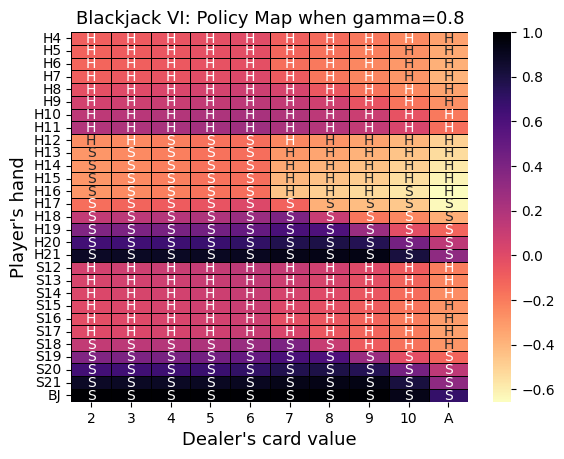

In [33]:
# run VI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(blackjack.P, blackjack).value_iteration(gamma=0.8, n_iters=1000, theta=1e-10)
toc = time.perf_counter()
print(f'VI wall clock time: {toc-tic}')

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=1000000, nproc=6)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

#test policy
test_scores = test_env(env=blackjack, n_iters=1000000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

unique_values, counts = np.unique(test_scores, return_counts=True)
print(unique_values)
print(counts)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack VI: Policy Map when gamma=0.8"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

mean_v_per_iter_02 = mean_v_per_iter
R_track_02 = R_track
pi_02 = pi



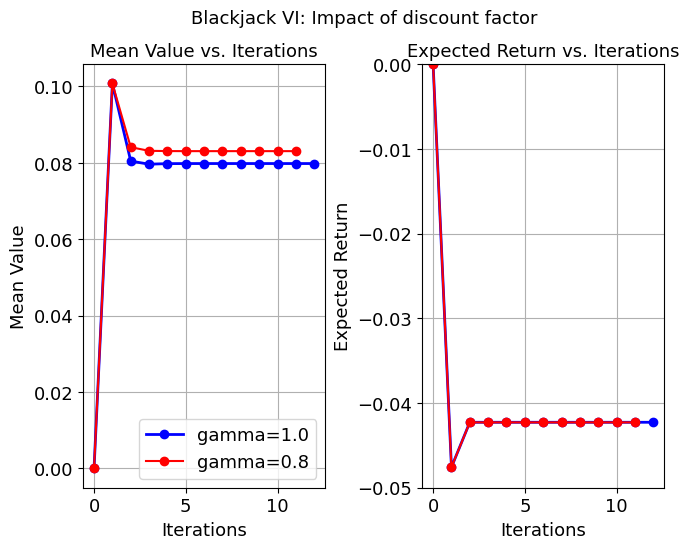

In [34]:
fontsize = 13

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(7.5, 5.5))

ax1.plot(range(mean_v_per_iter_01.shape[0]), mean_v_per_iter_01, '-o', color='blue', label='gamma=1.0', linewidth=2.0)
ax1.plot(range(mean_v_per_iter_02.shape[0]), mean_v_per_iter_02, '-o', color='red', label='gamma=0.8')
ax1.tick_params(labelsize=fontsize)
ax1.set_title('Mean Value vs. Iterations', fontsize=fontsize)
ax1.set_xlabel('Iterations', fontsize=fontsize) 
ax1.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
ax1.grid(True)
ax1.legend(fontsize=fontsize, loc='lower right')
#ax.set_ylim(-0.18, -0.04)
#fig.savefig('rhc_effect_max_attempts.png')

ax2.plot(R_track_01[:,0], R_track_01[:,1], '-o', color='blue', label='gamma=1.0', linewidth=2.0)
ax2.plot(R_track_02[:,0], R_track_02[:,1], '-o', color='red', label='gamma=0.8')
ax2.tick_params(labelsize=fontsize)
ax2.set_title('Expected Return vs. Iterations', fontsize=fontsize)
ax2.set_xlabel('Iterations', fontsize=fontsize) 
ax2.set_ylabel('Expected Return', fontsize=fontsize)
ax2.set_ylim(-0.05, 0)
ax2.grid(True)
#ax2.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)

fig.suptitle('Blackjack VI: Impact of discount factor', fontsize=fontsize) 
fig.subplots_adjust(wspace=0.4)
plt.show()
fig.savefig('bj_vi.png')
plt.close(fig)

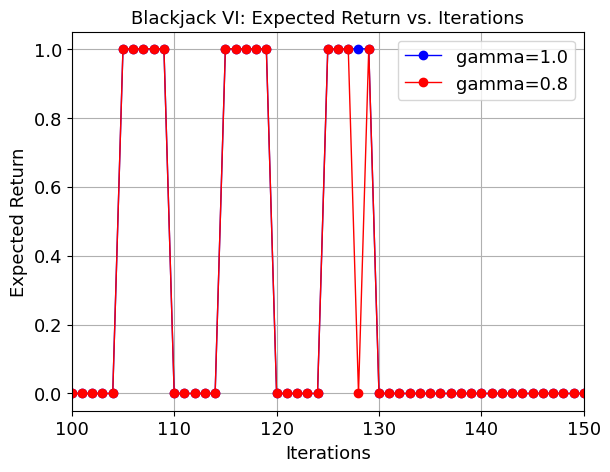

In [38]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_01.keys(), pi_01.values(), '-o', color='blue', label='gamma=1.0', linewidth=1.0)
ax.plot(pi_02.keys(), pi_02.values(),  '-o', color='red', label='gamma=0.8', linewidth=1.0)
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack VI: Expected Return vs. Iterations', fontsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
ax.set_xlim(100, 150)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)


PI wall clock time: 0.049523200003022794


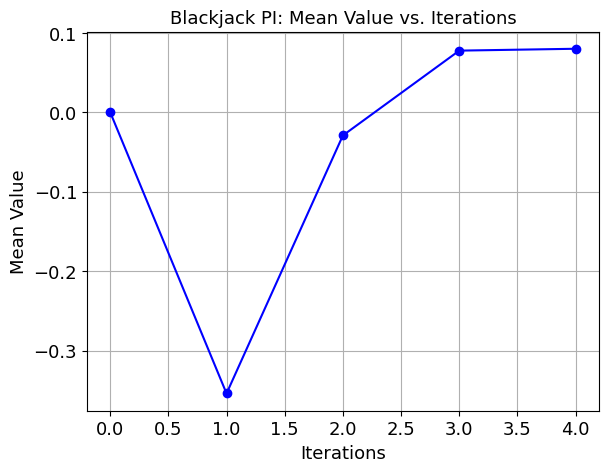

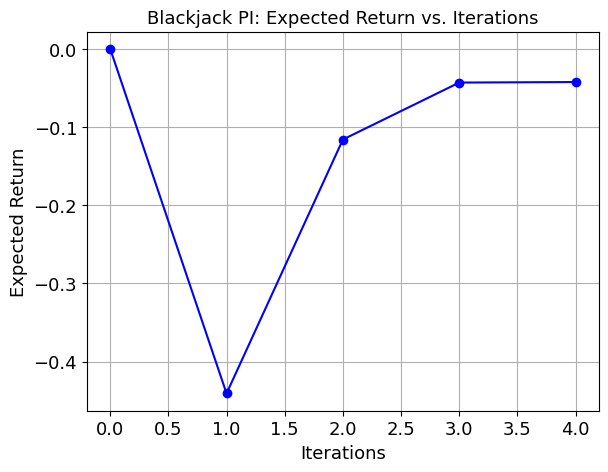

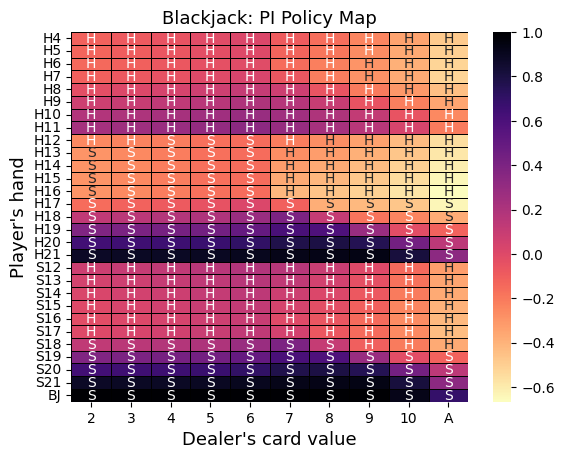

-0.04256
0.9530837562355157
[-1.  0.  1.]
[47637  8982 43381]


In [44]:
# run PI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(blackjack.P, blackjack).policy_iteration(gamma=1.0, n_iters=100, theta=1e-10)
toc = time.perf_counter()
print(f'PI wall clock time: {toc-tic}')

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(mean_v_per_iter.shape[0]), mean_v_per_iter, '-o', color='blue')
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack PI: Mean Value vs. Iterations', fontsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

#mean_r_per_iter = np.trim_zeros(R_track, 'b')

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue')
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack PI: Expected Return vs. Iterations', fontsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_ylim(-0.05, 0)
plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack: PI Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

unique_values, counts = np.unique(test_scores, return_counts=True)
print(unique_values)
print(counts)

mean_v_per_iter_PI01 = mean_v_per_iter
R_track_PI01 = R_track
pi_PI01 = pi


PI wall clock time: 0.03898279999702936


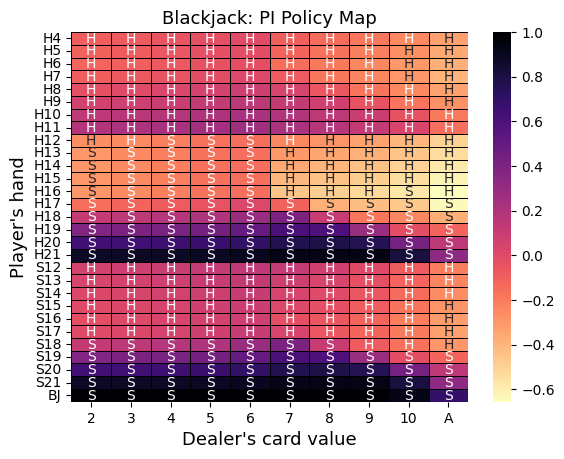

-0.04293
0.9543306633971267
[-1.  0.  1.]
[47776  8741 43483]


In [37]:
# run PI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(blackjack.P, blackjack).policy_iteration(gamma=0.8, n_iters=100, theta=1e-10)
toc = time.perf_counter()
print(f'PI wall clock time: {toc-tic}')

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack: PI Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

unique_values, counts = np.unique(test_scores, return_counts=True)
print(unique_values)
print(counts)

mean_v_per_iter_PI02 = mean_v_per_iter
R_track_PI02 = R_track
pi_PI02 = pi


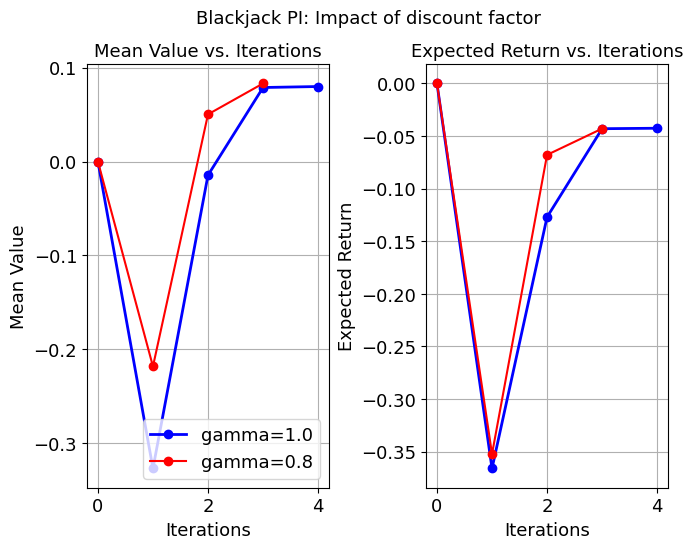

In [43]:
fontsize = 13

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(7.5, 5.5))

ax1.plot(range(mean_v_per_iter_PI01.shape[0]), mean_v_per_iter_PI01, '-o', color='blue', label='gamma=1.0', linewidth=2.0)
ax1.plot(range(mean_v_per_iter_PI02.shape[0]), mean_v_per_iter_PI02, '-o', color='red', label='gamma=0.8')
ax1.tick_params(labelsize=fontsize)
ax1.set_title('Mean Value vs. Iterations', fontsize=fontsize)
ax1.set_xlabel('Iterations', fontsize=fontsize) 
ax1.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
ax1.grid(True)
ax1.legend(fontsize=fontsize, loc='lower right')
#ax.set_ylim(-0.18, -0.04)
#fig.savefig('rhc_effect_max_attempts.png')

ax2.plot(R_track_PI01[:,0], R_track_PI01[:,1], '-o', color='blue', label='gamma=1.0', linewidth=2.0)
ax2.plot(R_track_PI02[:,0], R_track_PI02[:,1], '-o', color='red', label='gamma=0.8')
ax2.tick_params(labelsize=fontsize)
ax2.set_title('Expected Return vs. Iterations', fontsize=fontsize)
ax2.set_xlabel('Iterations', fontsize=fontsize) 
ax2.set_ylabel('Expected Return', fontsize=fontsize)
#ax2.set_ylim(-0.05, 0)
ax2.grid(True)
#ax2.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)

fig.suptitle('Blackjack PI: Impact of discount factor', fontsize=fontsize) 
fig.subplots_adjust(wspace=0.4)
plt.show()
fig.savefig('bj_pi.png')
plt.close(fig)

In [25]:
import importlib
importlib.reload(rl)
from rl import RL

In [26]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.2, epsilon_decay_ratio=0.5, min_epsilon=0.01, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d05_a02 = R_track
pi_track_d05_a02 = pi_track
V_track_Q_d05_a02 = V_track_Q

#del R_track, pi_track, V_track_Q

#fontsize = 13
#fig = plt.figure()
#ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(e_track, R_track, '-o', color='blue')
#ax.tick_params(labelsize=fontsize)
#ax.set_title('Mean Reward after Q-Learning Episodes', fontsize=fontsize)
#ax.set_xlabel('Q-Learning Episodes', fontsize=fontsize) 
#ax.set_ylabel('Mean Reward', fontsize=fontsize)
##ax.set_xlim(0, 150000)
#plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
#plt.show()
##fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)

QL wall clock time: 90.98984109982848
-0.04566
0.9518798056477509


In [27]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.8, epsilon_decay_ratio=0.5, min_epsilon=0.01, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d05_a08 = R_track
pi_track_d05_a08 = pi_track
V_track_Q_d05_a08 = V_track_Q

#del R_track, pi_track, V_track_Q

#fontsize = 13
#fig = plt.figure()
#ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(e_track, R_track, '-o', color='blue')
#ax.tick_params(labelsize=fontsize)
#ax.set_title('Mean Reward after Q-Learning Episodes', fontsize=fontsize)
#ax.set_xlabel('Q-Learning Episodes', fontsize=fontsize) 
#ax.set_ylabel('Mean Reward', fontsize=fontsize)
##ax.set_xlim(0, 150000)
#plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
#plt.show()
##fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)

QL wall clock time: 90.37410590006039
-0.04802
0.9522888635282889


In [29]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.5, min_epsilon=0.01, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d05 = R_track
pi_track_d05 = pi_track
V_track_Q_d05 = V_track_Q

#del R_track, pi_track, V_track_Q

#fontsize = 13
#fig = plt.figure()
#ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(e_track, R_track, '-o', color='blue')
#ax.tick_params(labelsize=fontsize)
#ax.set_title('Mean Reward after Q-Learning Episodes', fontsize=fontsize)
#ax.set_xlabel('Q-Learning Episodes', fontsize=fontsize) 
#ax.set_ylabel('Mean Reward', fontsize=fontsize)
##ax.set_xlim(0, 150000)
#plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
#plt.show()
##fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)

QL wall clock time: 90.49872690020129
-0.0455
0.9524965879203977


In [38]:
np.save('V_track_Q_d05_a08', V_track_Q_d05_a08)
np.save('V_track_Q_d05',     V_track_Q_d05)
np.save('V_track_Q_d05_a02', V_track_Q_d05_a02)

np.save('R_track_d05_a08', R_track_d05_a08)
np.save('R_track_d05',     R_track_d05)
np.save('R_track_d05_a02', R_track_d05_a02)

In [50]:
V_track_Q_d05_a08 = np.load('V_track_Q_d05_a08.npy')
V_track_Q_d05     = np.load('V_track_Q_d05.npy')
V_track_Q_d05_a02 = np.load('V_track_Q_d05_a02.npy')

R_track_d05_a08 = np.load('R_track_d05_a08.npy')
R_track_d05     = np.load('R_track_d05.npy')
R_track_d05_a02 = np.load('R_track_d05_a02.npy')

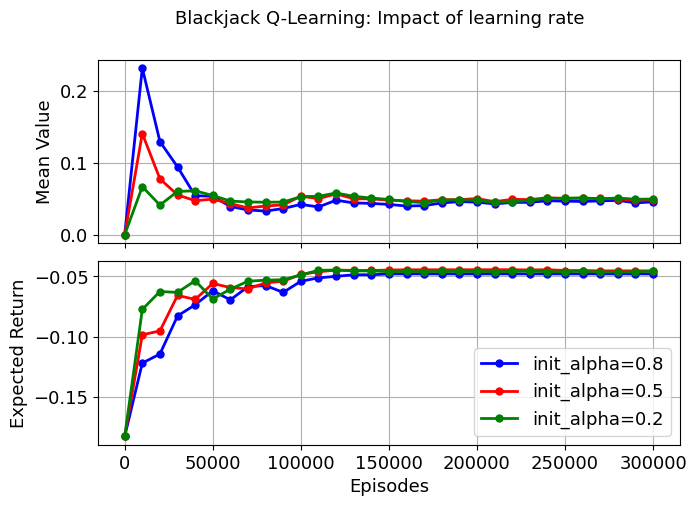

In [63]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

fontsize = 13
#fig = plt.figure()
#ax = fig.add_axes([0.15, 0.14, 0.80, 0.40])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7.5, 5))

ax1.plot(Q_track_episodes, np.mean(V_track_Q_d05_a08, axis=1), '-o', color='blue', label='init_alpha=0.8', markersize=5, linewidth=2)
ax1.plot(Q_track_episodes, np.mean(V_track_Q_d05, axis=1), '-o', color='red', label='init_alpha=0.5', markersize=5, linewidth=2)
ax1.plot(Q_track_episodes, np.mean(V_track_Q_d05_a02, axis=1), '-o', color='green', label='init_alpha=0.2', markersize=5, linewidth=2)

ax1.tick_params(labelsize=fontsize)
#ax.set_title('Blackjack: Q-L with eps_decay=0.5, min_eps=0.01', fontsize=fontsize)
#ax1.set_title('Blackjack Q-L: Impact of alpha on state value', fontsize=fontsize)
#ax1.set_xlabel('Episodes', fontsize=fontsize) 
ax1.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
ax1.grid(True)
#ax1.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
#plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)


#fontsize = 13
#fig = plt.figure()
#ax = fig.add_axes([0.15, 0.14, 0.80, 0.40])
ax2.plot(pi_track_episodes, R_track_d05_a08[:,1], '-o', color='blue', label='init_alpha=0.8', markersize=5, linewidth=2)
ax2.plot(pi_track_episodes, R_track_d05[:,1], '-o', color='red', label='init_alpha=0.5', markersize=5, linewidth=2)
ax2.plot(pi_track_episodes, R_track_d05_a02[:,1], '-o', color='green', label='init_alpha=0.2', markersize=5, linewidth=2)

ax2.tick_params(labelsize=fontsize)
#ax2.set_title('Blackjack Q-L: Impact of alpha on expected return', fontsize=fontsize)
ax2.set_xlabel('Episodes', fontsize=fontsize) 
ax2.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
ax2.grid(True)
ax2.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)

fig.suptitle('Blackjack Q-Learning: Impact of learning rate', fontsize=fontsize) 
fig.subplots_adjust(hspace=0.1)
plt.show()
fig.savefig('bj_ql_alpha.png')
plt.close(fig)


In [39]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.1, min_epsilon=0.01, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d01 = R_track
pi_track_d01 = pi_track
V_track_Q_d01 = V_track_Q


QL wall clock time: 96.05178570002317
-0.06578
0.9511955590728963


In [42]:
np.save('V_track_Q_d01', V_track_Q_d01)
np.save('R_track_d01', R_track_d01)

In [40]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.9, min_epsilon=0.01, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d09 = R_track
pi_track_d09 = pi_track
V_track_Q_d09 = V_track_Q

np.save('V_track_Q_d09', V_track_Q_d09)
np.save('R_track_d09', R_track_d09)

QL wall clock time: 87.58304460020736
-0.04685
0.9518797600012304


In [43]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.5, min_epsilon=0.10, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d05_m01 = R_track
pi_track_d05_m01 = pi_track
V_track_Q_d05_m01 = V_track_Q

np.save('V_track_Q_d05_m01', V_track_Q_d05_m01)
np.save('R_track_d05_m01', R_track_d05_m01)


QL wall clock time: 87.86746959993616
-0.04479
0.9534484023270479


In [44]:
n_episodes = 300000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.5, min_epsilon=0.30, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'QL wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d05_m03 = R_track
pi_track_d05_m03 = pi_track
V_track_Q_d05_m03 = V_track_Q

np.save('V_track_Q_d05_m03', V_track_Q_d05_m03)
np.save('R_track_d05_m03', R_track_d05_m03)


QL wall clock time: 81.63841109955683
-0.04557
0.9538937965517965


In [74]:
V_track_Q_d01     = np.load('V_track_Q_d01.npy')
V_track_Q_d09     = np.load('V_track_Q_d09.npy')
R_track_d01     = np.load('R_track_d01.npy')
R_track_d09     = np.load('R_track_d09.npy')


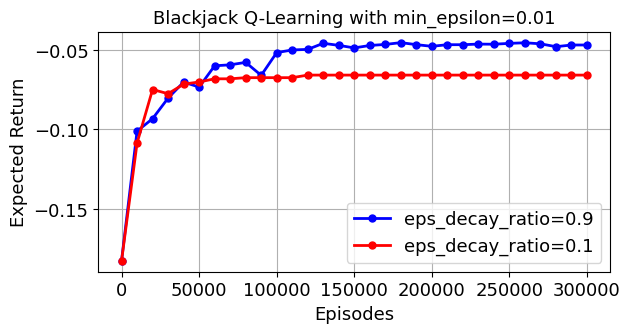

In [75]:
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.50])
ax.plot(pi_track_episodes, R_track_d09[:,1], '-o', color='blue', label='eps_decay_ratio=0.9', markersize=5, linewidth=2)
ax.plot(pi_track_episodes, R_track_d01[:,1], '-o', color='red', label='eps_decay_ratio=0.1', markersize=5, linewidth=2)
#ax.plot(pi_track_episodes, R_track_d05[:,1], '-o', color='red', label='eps_decay=0.5', markersize=5, linewidth=2)


ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack Q-Learning with min_epsilon=0.01', fontsize=fontsize)
ax.set_xlabel('Episodes', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
fig.savefig('bj_ql_eps_decay.png')
plt.close(fig)

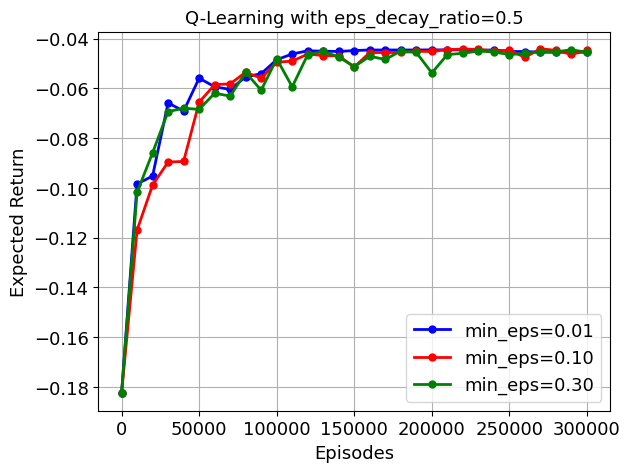

In [47]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_track_episodes, R_track_d05[:,1], '-o', color='blue', label='min_eps=0.01', markersize=5, linewidth=2)
ax.plot(pi_track_episodes, R_track_d05_m01[:,1], '-o', color='red', label='min_eps=0.10', markersize=5, linewidth=2)
ax.plot(pi_track_episodes, R_track_d05_m03[:,1], '-o', color='green', label='min_eps=0.30', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Q-Learning with eps_decay_ratio=0.5', fontsize=fontsize)
ax.set_xlabel('Episodes', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [16]:

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.5, min_epsilon=0.20, n_episodes=300000)
toc = time.perf_counter()
print(f'PI wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=10000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
#mean_v_per_iter = np.trim_zeros(np.mean(V_track_Q, axis=1), 'b')
#Plots.v_iters_plot(mean_v_per_iter, "Blackjack\nMean Value v Iterations")

every_Q_episodes = 10000
n_episodes_R = 10000
R_track = []
e_track = []
env = blackjack
for e in range(len(pi_track)):
    if (e % every_Q_episodes == 0.0 or e==len(pi_track)-1):
        # Test policy and track total reward
        pi = {s:a for s, a in enumerate(pi_track[e])}
        test_scores = test_env(env=env, n_iters=n_episodes_R, pi=pi)
        e_track.append(e)
        R_track.append(np.mean(test_scores))

R_track_d05_m02 = R_track
pi_track_d05_m02 = pi_track
V_track_Q_d05_m02 = V_track_Q

#fontsize = 13
#fig = plt.figure()
#ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(e_track, R_track, '-o', color='blue')
#ax.tick_params(labelsize=fontsize)
#ax.set_title('Mean Reward after Q-Learning Episodes', fontsize=fontsize)
#ax.set_xlabel('Q-Learning Episodes', fontsize=fontsize) 
#ax.set_ylabel('Mean Reward', fontsize=fontsize)
##ax.set_xlim(0, 150000)
#plt.grid(True)
#ax.set_ylim(-0.18, -0.04)
#plt.show()
##fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)

PI wall clock time: 88.553792900173
-0.044
0.95439195302559


In [5]:
from multiprocessing import Pool
import importlib
importlib.reload(workers_a4)
import workers_a4

n_episodes_list = [100000, 200000, 300000, 400000]
min_eps_list = [0.01, 0.05, 0.1, 0.2]
decay_eps_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

output_file = 'bj_QL_grid_seach'

parameters = []

for i, n_episodes in enumerate(n_episodes_list):
    for j, min_eps in enumerate(min_eps_list):
        for k, decay_eps in enumerate(decay_eps_list):
            
            parameters.append((decay_eps, min_eps, n_episodes, output_file))

print('decay_eps', 'min_eps', 'n_episodes', file=open(output_file+'_progress.txt', 'a'))
print('decay_eps', 'min_eps', 'n_episodes', 'exp_R', 'time', file=open(output_file+'_results.txt', 'a'))

if __name__ ==  '__main__':
    p=Pool(processes = 6)
    p.map(workers_a4.bj_QL_grid_seach, parameters)
    print('Done!')

Done!


In [5]:
df_grid_search = pd.read_csv('bj_QL_grid_seach_results.txt', sep=' ')

In [6]:
df_grid_search.sort_values(by=['exp_R'], ascending=False)

,decay_eps,min_eps,n_episodes,exp_R,time
110,0.9,0.20,400000,-0.04349,475.582254
109,0.5,0.10,400000,-0.04358,480.841965
90,0.8,0.01,400000,-0.04363,415.135642
47,0.8,0.20,200000,-0.04373,120.043263
19,0.7,0.10,100000,-0.04379,43.913318
...,...,...,...,...,...
15,0.2,0.05,100000,-0.05696,47.929420
16,0.4,0.01,100000,-0.05788,47.864353
21,0.3,0.05,100000,-0.05876,45.845974
26,0.4,0.05,100000,-0.05956,48.861344


PI wall clock time: 105.74978689999989
-0.04349
0.9538546115105802


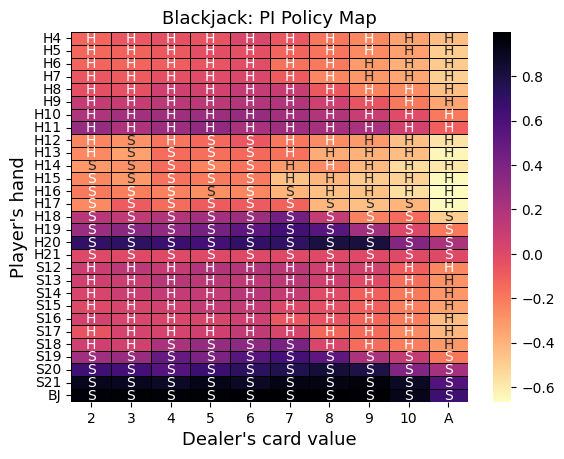

[-1.  0.  1.]
[47761  8827 43412]


In [7]:
n_episodes = 400000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.9, min_epsilon=0.2, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes)
toc = time.perf_counter()
print(f'PI wall clock time: {toc-tic}')

#test policy
test_scores = test_env(env=blackjack, n_iters=100000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d09_m02 = R_track
pi_track_d09_m02 = pi_track
V_track_Q_d09_m02 = V_track_Q

np.save('V_track_Q_d09_m02', V_track_Q_d09_m02)
np.save('R_track_d09_m02', R_track_d09_m02)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack: PI Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

unique_values, counts = np.unique(test_scores, return_counts=True)
print(unique_values)
print(counts)

In [11]:
R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=100000, nproc=6)

R_track_d09_m02 = R_track
pi_track_d09_m02 = pi_track
V_track_Q_d09_m02 = V_track_Q

np.save('V_track_Q_d09_m02', V_track_Q_d09_m02)
np.save('R_track_d09_m02', R_track_d09_m02)

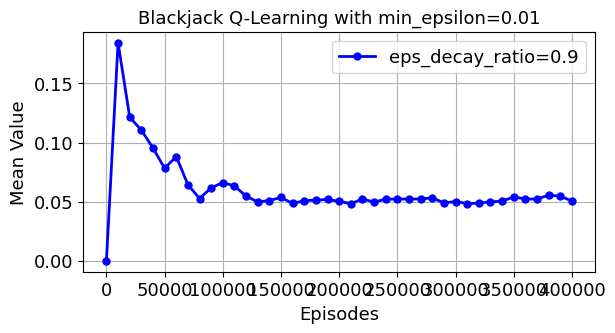

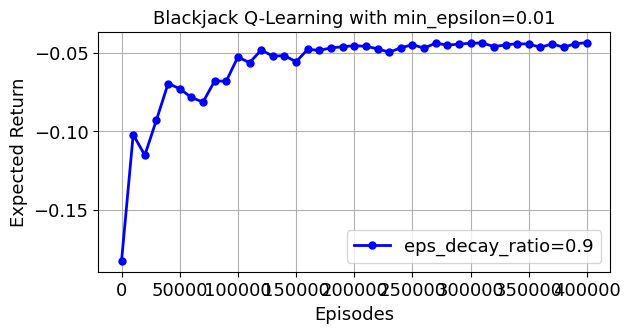

In [13]:
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.50])
ax.plot(Q_track_episodes, np.mean(V_track_Q_d09_m02, axis=1), '-o', color='blue', label='eps_decay_ratio=0.9', markersize=5, linewidth=2)
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack Q-Learning with min_epsilon=0.01', fontsize=fontsize)
ax.set_xlabel('Episodes', fontsize=fontsize) 
ax.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('bj_ql_eps_decay.png')
plt.close(fig)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.50])
ax.plot(pi_track_episodes, R_track[:,1], '-o', color='blue', label='eps_decay_ratio=0.9', markersize=5, linewidth=2)
ax.tick_params(labelsize=fontsize)
ax.set_title('Blackjack Q-Learning with min_epsilon=0.01', fontsize=fontsize)
ax.set_xlabel('Episodes', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('bj_ql_eps_decay.png')
plt.close(fig)



In [5]:
from multiprocessing import Pool
import importlib
importlib.reload(workers_a4)
importlib.reload(rl)
import workers_a4
from rl import RL

init_alpha_list = [0.2, 0.5, 0.8]
n_episodes_list = [100000, 200000, 300000, 400000]
min_eps_list = [0.05, 0.1, 0.2, 0.3]
decay_eps_list = [0.5, 0.6, 0.7, 0.8, 0.9]

output_file = 'bj_QL_grid_search_v3'

parameters = []
seed=100
for i, n_episodes in enumerate(n_episodes_list):
    for j, min_eps in enumerate(min_eps_list):
        for k, decay_eps in enumerate(decay_eps_list):
            for kk, init_alpha in enumerate(init_alpha_list):

                seed += 1
                
                parameters.append((seed, init_alpha, decay_eps, min_eps, n_episodes, output_file))

print('seed','init_alpha','decay_eps', 'min_eps', 'n_episodes', file=open(output_file+'_progress.txt', 'a'))
print('seed','init_alpha','decay_eps', 'min_eps', 'n_episodes', 'exp_R', 'time', file=open(output_file+'_results.txt', 'a'))

if __name__ ==  '__main__':
    p=Pool(processes = 6)
    p.map(workers_a4.bj_QL_grid_seach, parameters)
    print('Done!')

Done!


In [7]:
df_grid_search_v3 = pd.read_csv('bj_QL_grid_search_v3_results.txt', sep=' ')
df_grid_search_v3.sort_values(by=['exp_R'], ascending=False)

,seed,init_alpha,decay_eps,min_eps,n_episodes,exp_R,time
89,195,0.5,0.6,0.20,200000,-0.04240,104.757432
121,231,0.5,0.8,0.05,300000,-0.04277,216.592652
123,251,0.2,0.5,0.20,300000,-0.04298,236.865034
99,207,0.5,0.5,0.30,200000,-0.04316,97.660636
214,336,0.5,0.8,0.30,400000,-0.04321,445.608985
...,...,...,...,...,...,...,...
35,106,0.8,0.6,0.05,100000,-0.05146,45.802428
22,124,0.8,0.7,0.10,100000,-0.05159,48.412990
56,140,0.2,0.8,0.20,100000,-0.05165,40.308935
216,287,0.2,0.7,0.05,400000,-0.05168,419.688861


In [35]:
n_episodes = 200000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

# Q-learning
tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(gamma=0.99, init_alpha=0.5, epsilon_decay_ratio=0.6, min_epsilon=0.2, n_episodes=n_episodes,
                                                      Q_track_episodes=Q_track_episodes, 
                                                      pi_track_episodes=pi_track_episodes, seed=195)
toc = time.perf_counter()
print(f'PI wall clock time: {toc-tic}')

##test policy
#test_scores = test_env(env=blackjack, n_iters=1000000, pi=pi)
#print(np.mean(test_scores))
#print(np.std(test_scores))
#
#V_track_Q = np.max(Q_track, axis=2)
#
#R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=1000000, nproc=6)
#
#R_track_d06_m02 = R_track
#pi_track_d06_m02 = pi_track
#V_track_Q_d06_m02 = V_track_Q
#
#np.save('V_track_Q_d06_m02', V_track_Q_d06_m02)
#np.save('R_track_d06_m02', R_track_d06_m02)
#
##get formatted state values and policy map
#val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)
#
#title = "Blackjack: PI Policy Map"
#Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)
#
#unique_values, counts = np.unique(test_scores, return_counts=True)
#print(unique_values)
#print(counts)

PI wall clock time: 57.68885659999796


-0.042535
0.9534221382866038


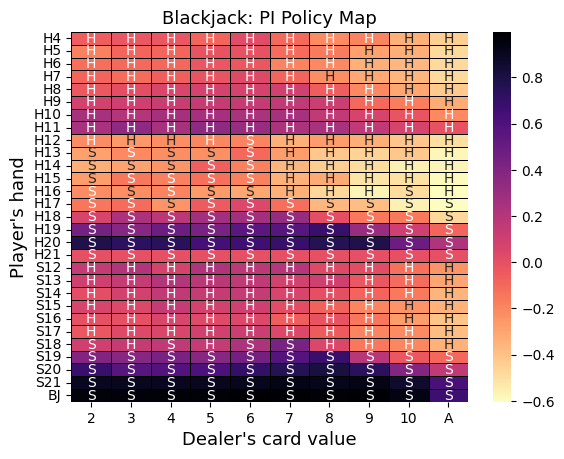

[-1.  0.  1.]
[476679  89177 434144]


In [9]:
#test policy
test_scores = test_env(env=blackjack, n_iters=1000000, pi=pi)
print(np.mean(test_scores))
print(np.std(test_scores))

V_track_Q = np.max(Q_track, axis=2)

R_track = bj_expected_reward_history(pi_track=pi_track, output_step=1, n_episodes=1000000, nproc=6)

R_track_d06_m02 = R_track
pi_track_d06_m02 = pi_track
V_track_Q_d06_m02 = V_track_Q

np.save('V_track_Q_d06_m02', V_track_Q_d06_m02)
np.save('R_track_d06_m02', R_track_d06_m02)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack: PI Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

unique_values, counts = np.unique(test_scores, return_counts=True)
print(unique_values)
print(counts)

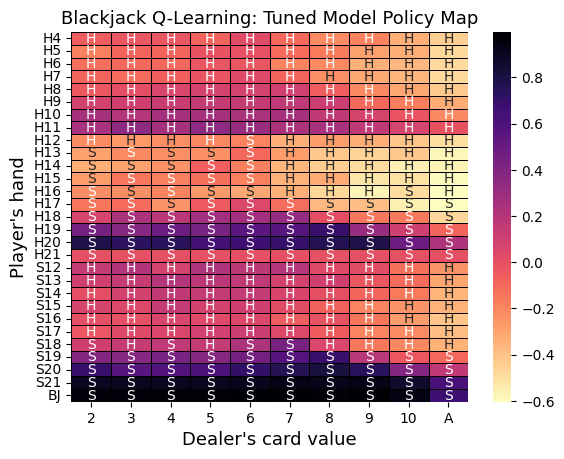

In [31]:
V_track_Q_d06_m02 = np.load('V_track_Q_d06_m02.npy')
R_track_d06_m02   = np.load('R_track_d06_m02.npy')
#pi_track_d06_m02  = np.load('pi_track_d06_m02.npy')

V = V_track_Q_d06_m02[-1,:]
pi = {s: a for s, a in enumerate(pi_track_d06_m02[-1])}

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

title = "Blackjack Q-Learning: Tuned Model Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

In [28]:
V_track_Q_d06_m02.shape

(21, 290)

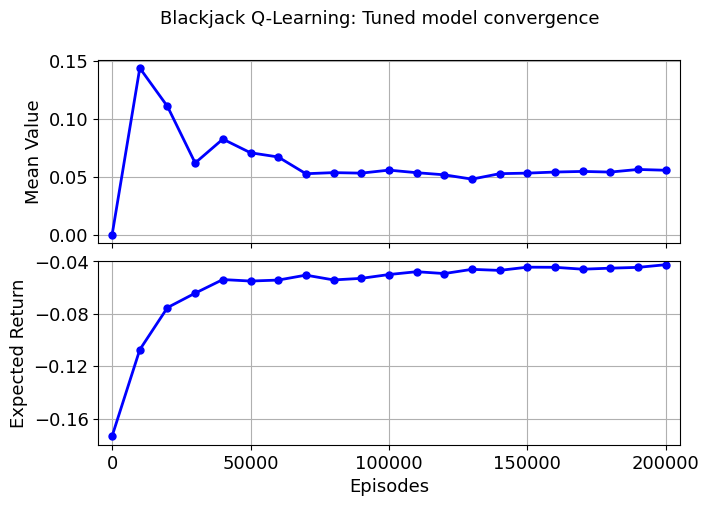

In [25]:
V_track_Q_d06_m02 = np.load('V_track_Q_d06_m02.npy')
R_track_d06_m02   = np.load('R_track_d06_m02.npy')

n_episodes = 200000
Q_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]
pi_track_episodes = list(range(0, n_episodes, 10000)) + [n_episodes-1]

fontsize = 13
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7.5, 5))

ax1.plot(Q_track_episodes, np.mean(V_track_Q_d06_m02, axis=1), '-o', color='blue', markersize=5, linewidth=2)
ax1.tick_params(labelsize=fontsize)
#ax1.set_title('Blackjack Q-Learning ', fontsize=fontsize)
#ax1.set_xlabel('Episodes', fontsize=fontsize) 
ax1.set_ylabel('Mean Value', fontsize=fontsize)
#ax.set_xlim(0, 150000)
ax1.grid(True)
#ax1.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
#plt.show()
#fig.savefig('bj_ql_eps_decay.png')
#plt.close(fig)

ax2.plot(pi_track_episodes, R_track_d06_m02[:,1], '-o', color='blue', markersize=5, linewidth=2)
ax2.tick_params(labelsize=fontsize)
#ax2.set_title('Blackjack Q-Learning with min_epsilon=0.01', fontsize=fontsize)
ax2.set_xlabel('Episodes', fontsize=fontsize) 
ax2.set_ylabel('Expected Return', fontsize=fontsize)
ax2.set_xlim(-5000, 205000)
ax2.grid(True)
#ax2.legend(fontsize=fontsize)
ax2.set_ylim(-0.18, -0.04)
ax2.set_yticks([-0.16, -0.12, -0.08, -0.04])
ax2.set_xticks([0, 50000, 100000, 150000, 200000])
fig.suptitle('Blackjack Q-Learning: Tuned Model Convergence', fontsize=fontsize) 
fig.subplots_adjust(hspace=0.1)
plt.show()
fig.savefig('bj_ql_tuned_model.png')
plt.close(fig)

In [12]:
epsilons1 = RL.decay_schedule(init_value=1.0, min_value=0.1, decay_ratio=0.9, max_steps=150000, log_start=-2, log_base=10)
epsilons4 = RL.decay_schedule(init_value=1.0, min_value=0.1, decay_ratio=0.1, max_steps=150000, log_start=-2, log_base=10)
epsilons5 = RL.decay_schedule(init_value=1.0, min_value=0.5, decay_ratio=0.9, max_steps=150000, log_start=-2, log_base=10)

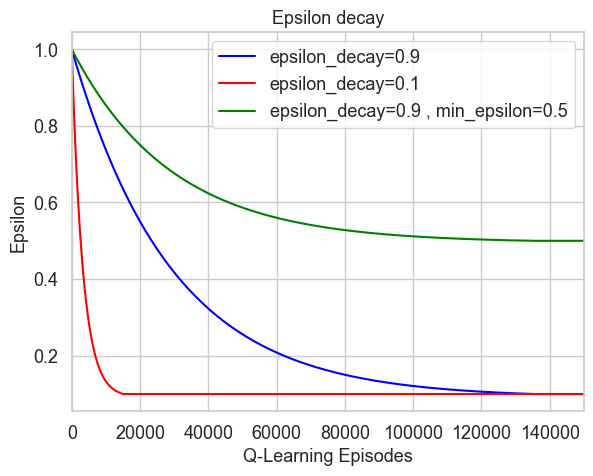

In [13]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(range(V_track_Q3.shape[0]), np.mean(V_track_Q3, axis=1), color='blue', label='init_alpha=0.7')
ax.plot(range(150000), epsilons1, color='blue', label='epsilon_decay=0.9')
ax.plot(range(150000), epsilons4, color='red',label='epsilon_decay=0.1')
ax.plot(range(150000), epsilons5, color='green',label='epsilon_decay=0.9 , min_epsilon=0.5')
ax.tick_params(labelsize=fontsize)
ax.set_title('Epsilon decay', fontsize=fontsize)
ax.set_xlabel('Q-Learning Episodes', fontsize=fontsize) 
ax.set_ylabel('Epsilon', fontsize=fontsize)
ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

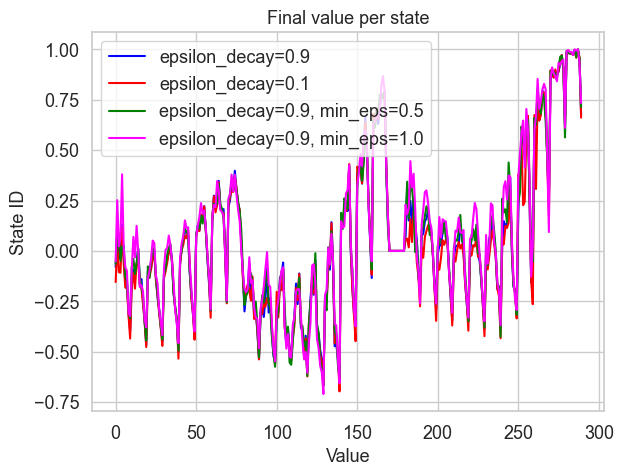

In [35]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(range(V_track_Q3.shape[0]), np.mean(V_track_Q3, axis=1), color='blue', label='init_alpha=0.7')
ax.plot(range(290), V_track_Q1[-1,:], color='blue', label='epsilon_decay=0.9')
ax.plot(range(290), V_track_Q4[-1,:], color='red',label='epsilon_decay=0.1')
ax.plot(range(290), V_track_Q5[-1,:], color='green',label='epsilon_decay=0.9, min_eps=0.5')
ax.plot(range(290), V_track_Q6[-1,:], color='magenta',label='epsilon_decay=0.9, min_eps=1.0')
ax.tick_params(labelsize=fontsize)
ax.set_title('Final value per state', fontsize=fontsize)
ax.set_xlabel('Value', fontsize=fontsize) 
ax.set_ylabel('State ID', fontsize=fontsize)
#ax.set_xlim(0, 50)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

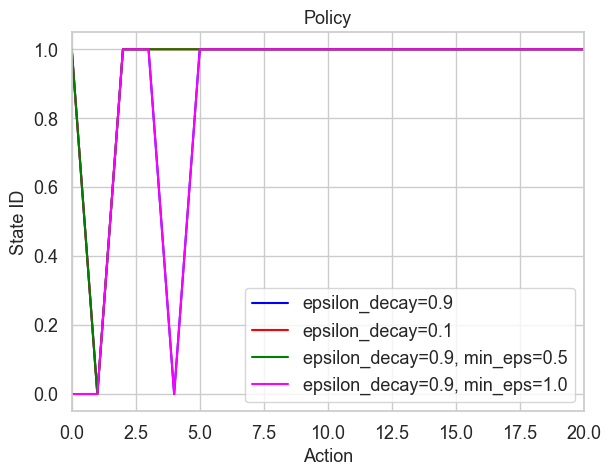

In [42]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
#ax.plot(range(V_track_Q3.shape[0]), np.mean(V_track_Q3, axis=1), color='blue', label='init_alpha=0.7')
ax.plot(range(290), pi_track1[-1], color='blue', label='epsilon_decay=0.9')
ax.plot(range(290), pi_track4[-1], color='red',label='epsilon_decay=0.1')
ax.plot(range(290), pi_track5[-1], color='green',label='epsilon_decay=0.9, min_eps=0.5')
ax.plot(range(290), pi_track6[-1], color='magenta',label='epsilon_decay=0.9, min_eps=1.0')
ax.tick_params(labelsize=fontsize)
ax.set_title('Policy', fontsize=fontsize)
ax.set_xlabel('Action', fontsize=fontsize) 
ax.set_ylabel('State ID', fontsize=fontsize)
ax.set_xlim(0, 20)
plt.grid(True)
ax.legend(fontsize=fontsize)
#ax.set_ylim(-0.18, -0.04)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)